## **1. Setup and Load Data**

### **1.1. Install Dependencies and Setup**

In [2]:
%pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip list

Package                 Version
----------------------- -----------
absl-py                 2.1.0
asttokens               2.4.1
astunparse              1.6.3
certifi                 2024.8.30
charset-normalizer      3.4.0
comm                    0.2.2
contourpy               1.3.1
cycler                  0.12.1
debugpy                 1.8.9
decorator               5.1.1
executing               2.1.0
flatbuffers             24.3.25
fonttools               4.55.0
gast                    0.6.0
google-pasta            0.2.0
grpcio                  1.68.0
h5py                    3.12.1
idna                    3.10
ipykernel               6.29.5
ipython                 8.29.0
jedi                    0.19.2
jupyter_client          8.6.3
jupyter_core            5.7.2
keras                   3.6.0
kiwisolver              1.4.7
libclang                18.1.1
Markdown                3.7
markdown-it-py          3.0.0
MarkupSafe              3.0.2
matplotlib              3.9.2
matplotlib-inline    

In [4]:
import tensorflow as tf
import os

2024-11-22 22:38:40.077028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 22:38:40.092582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 22:38:40.246671: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 22:38:40.371685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732289920.505197    7482 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732289920.53

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')

W0000 00:00:1732289928.950935    7482 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
# Avoid OOM (out-of-memory) errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### **1.2. Remove Dodgy Images**

In [40]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [33]:
data_dir = 'Dataset/Augmented/Training'
image_exts = ['jpeg']

In [45]:
img = cv2.imread(os.path.join(data_dir, 'NailMelanoma', 'NailMelanoma (1).jpg'))
img.shape

(256, 256, 3)

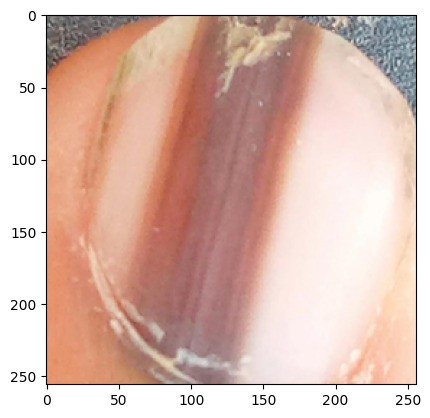

In [48]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [49]:
issues_count = 0

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            with Image.open(image_path) as img:
                img.verify()
                
                # Optional: get file extension check
                if img.format.lower() not in image_exts:
                    issues_count += 1
                    print(f"Image not in ext list {image_path}")
                    # os.remove(image_path)
        except Exception as e:
            issues_count += 1
            print(f"Issue with image {image_path}")
            print(e)
            # os.remove(image_path)

if issues_count == 0:
    print("No broken images found. Rejoice!")
else:
    print(f"There are {issues_count} broken images.")

No broken images found. Rejoice!


### **1.3. Load Data**

In [54]:
import numpy as np
from matplotlib import pyplot as plt

In [58]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1600 files belonging to 2 classes.


In [72]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [75]:
# Class 0 = Healthy Nail
# Class 1 = Nail Melanoma
batch[1]

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1], dtype=int32)

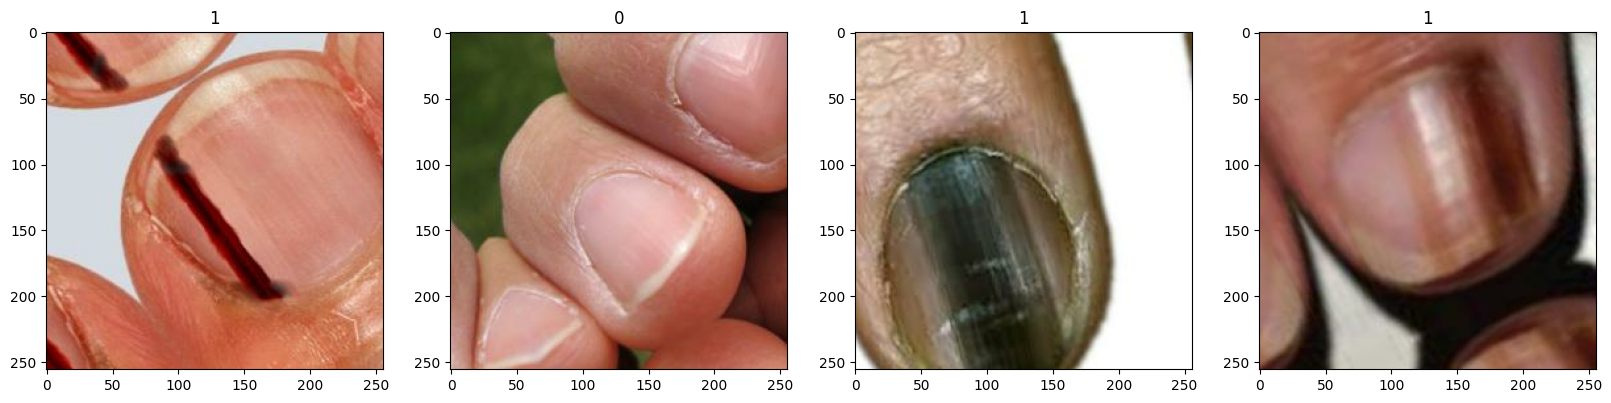

In [76]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## **2. Preprocess Data**

### **2.1. Scale Data**

In [81]:
# batch[0] are the images
# batch[1] are the labels
scaled = batch[0] / 255
scaled.max()

np.float32(1.0)

In [85]:
data = data.map(lambda img, label: (img / 255, label))
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>